In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.io import read_image

# Creating Training Dataframe

**Adding Images and Labels for different Types to the dataframe**

In [28]:
path = './'
train_df = pd.read_csv(path + 'train.csv')
train_df['Image'] = train_df['Id'].astype(str) + '.png'
train_df = train_df[train_df.columns[[0, 2, 1]]]
train_df['Type'] = train_df['Type'].astype('category')
train_df['Labels'] = train_df['Type'].cat.codes
train_df

,Id,Image,Type,Labels
0,1,1.png,Connective,1
1,2,2.png,Connective,1
2,3,3.png,Connective,1
3,4,4.png,Connective,1
4,5,5.png,Connective,1
...,...,...,...,...
2185,2186,2186.png,Immune,2
2186,2187,2187.png,Cancer,0
2187,2188,2188.png,Connective,1
2188,2189,2189.png,Connective,1


**Initial Count of different types in the dataframe**

In [29]:
train_df['Type'].value_counts()

 Immune        729
 Connective    726
 Cancer        546
 Normal        189
Name: Type, dtype: int64

# Balancing the Training data in the dataframe

**Doubling the Normal type image data in the dataframe**

In [30]:
normal_images = train_df.loc[train_df['Type'].values == ' Normal', 'Image']
last_id = train_df.iloc[-1]['Id'] + 1
j = 0
for i in range(len(normal_images)):
    if i % len(normal_images) == 0:
        j = 0
    train_df.loc[len(train_df.index)] = [last_id + i, normal_images.iloc[j], ' Normal', 3]
    j = j + 1
train_df

,Id,Image,Type,Labels
0,1,1.png,Connective,1
1,2,2.png,Connective,1
2,3,3.png,Connective,1
3,4,4.png,Connective,1
4,5,5.png,Connective,1
...,...,...,...,...
2374,2375,2086.png,Normal,3
2375,2376,2108.png,Normal,3
2376,2377,2169.png,Normal,3
2377,2378,2175.png,Normal,3


**Final count of different types after balancing the training data**

In [31]:
train_df['Type'].value_counts()

 Immune        729
 Connective    726
 Cancer        546
 Normal        378
Name: Type, dtype: int64

# Class for Creating the Training Dataset

In [32]:
class CustomImageDataset(Dataset):
    def __init__(self, data_frame, image_dir, transform=None):
        self.data_frame = data_frame
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_name  = os.path.join(self.image_dir, self.data_frame.iloc[idx, 1])
        images = read_image(image_name)
        labels = torch.from_numpy(np.array(self.data_frame.iloc[idx, -1])).long()
        images = images.type(torch.FloatTensor)
        images = images / 255.0
        if self.transform:
            images = self.transform(images)
            
        return (images, labels)

# Data Augmentation

In [33]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(0, shear=8, scale=(0.8,1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# Creating Training Dataset

In [34]:
train_dataset = CustomImageDataset(
    data_frame = train_df,
    image_dir = path + 'train/train',
    transform = train_transform
)

# Creating Train Loader and Test Loader by splitting Training Dataset 

In [35]:
batch_size = 10
test_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler)

# Model Architecture

In [36]:
class cnNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 64, 5, 1, 2)
        self.fc1 = nn.Linear(8*8*64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 8*8*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Creating Loss Function and Optimzer

In [37]:
torch.manual_seed(101)
cnnModel = cnNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnnModel.parameters(), lr=0.001)
cnnModel

cnNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

# Training the Model

In [38]:
import time
start_time = time.time()

epochs = 12

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    correct_train_values = 0
    correct_test_values = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b = b + 1
       
        y_pred = cnnModel(X_train)
        loss = criterion(y_pred, y_train)
        train_predict = torch.max(y_pred.data, 1)[1]
        correct_train_values += (train_predict == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(loss)
    train_correct.append(correct_train_values)
    print(f'Epoch:{i} \t Loss:{loss.item():10.8f} \t Train accuracy:{correct_train_values.item()*100/(batch_size*len(train_loader)):7.3f}%')
        
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = cnnModel(X_test)
            test_predict = torch.max(y_val.data, 1)[1] 
            correct_test_values += (test_predict == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(correct_test_values)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:0 	 Loss:1.14199448 	 Train accuracy: 38.848%
Epoch:1 	 Loss:1.03242111 	 Train accuracy: 52.723%
Epoch:2 	 Loss:0.59395438 	 Train accuracy: 61.780%
Epoch:3 	 Loss:1.13437891 	 Train accuracy: 66.859%
Epoch:4 	 Loss:0.92975032 	 Train accuracy: 67.173%
Epoch:5 	 Loss:0.61689836 	 Train accuracy: 70.052%
Epoch:6 	 Loss:1.32511437 	 Train accuracy: 71.990%
Epoch:7 	 Loss:0.15233302 	 Train accuracy: 72.984%
Epoch:8 	 Loss:0.66413653 	 Train accuracy: 73.979%
Epoch:9 	 Loss:0.32157385 	 Train accuracy: 76.387%
Epoch:10 	 Loss:0.61243749 	 Train accuracy: 75.812%
Epoch:11 	 Loss:0.55644965 	 Train accuracy: 78.586%

Duration: 303 seconds


# Plotting Training and Test Loss

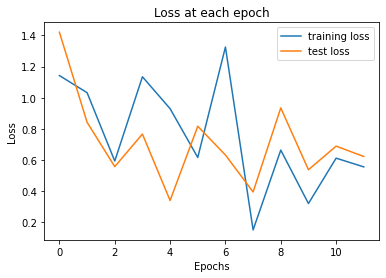

In [62]:
trainLosses = [train_loss.detach().numpy() for train_loss in train_losses]
testLosses = [test_loss.detach().numpy() for test_loss in test_losses]
plt.plot(trainLosses, label='training loss')
plt.plot(testLosses, label='test loss')
plt.title('Loss at each epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

# Plotting Training and Test Accuracy

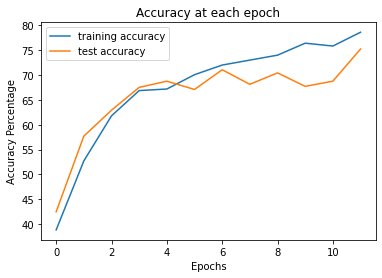

In [61]:
plt.plot([t/(len(train_loader)*batch_size/100) for t in train_correct], label='training accuracy')
plt.plot([t/(len(test_loader)*batch_size/100) for t in test_correct], label='test accuracy')
plt.title('Accuracy at each epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Percentage')
plt.legend();

**Test Accuracy of the Model**

In [55]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/(batch_size*len(test_loader)):.3f}%')

[tensor(204), tensor(277), tensor(302), tensor(324), tensor(330), tensor(322), tensor(341), tensor(327), tensor(338), tensor(325), tensor(330), tensor(361)]
Test accuracy: 75.208%


# Validating the given Test Dataset

In [56]:
root = './'
valid_dataset = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Creating the Predicted Test Data in the CSV file 

In [57]:
class_names = ['Cancer', 'Connective', 'Immune', 'Normal']

predicts = []
with torch.no_grad():
    for images,labels in valid_loader:
        y_val = cnnModel(images)
        val_predict = torch.max(y_val.data, 1)[1]
        predicts.append(val_predict)
predicts = torch.cat(predicts)
id = np.arange(10001, 10401)
type = np.array([class_names[i] for i in predicts])
dict = {'Id': id, 'Type': type}
df = pd.DataFrame(dict)
df.to_csv('predicted_test.csv', index=False)

df['Type'].value_counts()

Connective    165
Cancer        120
Immune         58
Normal         57
Name: Type, dtype: int64